# **PHASE 1 : TRAITEMENT DES IMAGES**

# **1 - Importation des bibliothèques**

In [1]:
import cv2 # pour afficher les images
import pandas as pd # pour manipuler les fichiers csv
import numpy as np # bibliothèque de l'algèbre linéaire
import matplotlib.pyplot as plt # pour le traçage des graphes
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split # pour fractionner les données
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pour traiter les images

# **2 - Préparation des données**

In [2]:
csv_path = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv' 
train_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/' 
test_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

In [3]:
data = pd.read_csv(csv_path) # pour accéder au fichier csv
Train = data[data['Dataset_type'] == 'TRAIN'] # les données d'entrainement
Train = Train[['X_ray_image_name', 'Label']] 
Test = data[data['Dataset_type'] == 'TEST'] # les données de prédiction
Test = Test[['X_ray_image_name', 'Label']]
Train, Valid = train_test_split(Train, test_size=0.2, stratify=Train['Label'], random_state=38) # les données d'entrainement et de validation

In [4]:
Generator_1 = ImageDataGenerator(rescale=1/255.)
Generator_2 = ImageDataGenerator( rescale = 1./255,
                                width_shift_range = 0.15,
                                height_shift_range = 0.15,
                                zoom_range = [0.9, 1.25],
                                brightness_range = [0.5, 1.5]
                                )  
targetSize = (224, 224) # la taille commune sera 224x224
batchSize = 32 # pour regrouper les images (32 images par groupe)
classMode = 'binary' # nous avons deux classes : 0 et 1
colorMode = 'rgb'  # rgb pour red/green/blue , 3 dimensions

Final_Train = Generator_2.flow_from_dataframe(
    dataframe = Train,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True # reorganniser les images 
    )

Final_Valid = Generator_1.flow_from_dataframe(
    dataframe = Valid,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Final_Test = Generator_1.flow_from_dataframe(
    dataframe = Test,
    directory = test_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# **PHASE 2 : ENTRAINEMENT**

# **1 - Importation des bibliothèques**

In [5]:
# Pour l'apprentissage profond
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as tf_hub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **2 - Le choix des métriques**

In [6]:
metrics = ['accuracy',keras.metrics.Precision(name='precision')]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

2022-05-30 21:07:49.877851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:07:49.983859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:07:49.984689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:07:49.985794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **3 - Le modèle : EfficientNet V2 B0**

In [7]:
tf.random.set_seed(38)

efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'
feature_extractor_layer = tf_hub.KerasLayer(efficientnetv2_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224, 224, 3,))

efficientnet_model = tf.keras.Sequential([
                            feature_extractor_layer, 
                            tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')
                            ])

efficientnet_model.compile(loss = 'binary_crossentropy',
                           optimizer = Adam(learning_rate = 5e-5),
                           metrics = metrics)
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 5,920,593
Trainable params: 1,281
Non-trainable params: 5,919,312
_________________________________________________________________


In [8]:
efficientnet_history = efficientnet_model.fit(Final_Train,
                                              epochs = 30, 
                                              validation_data = Final_Valid,
                                              steps_per_epoch = len(Final_Train),
                                              validation_steps = len(Final_Valid),
                                              callbacks = callbacks)

2022-05-30 21:08:00.996069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-30 21:08:08.795326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


133/133 [==============================] - 151s 1s/step - loss: 0.6548 - accuracy: 0.6003 - precision: 0.7694 - val_loss: 0.6410 - val_accuracy: 0.6191 - val_precision: 0.7566
Epoch 2/30
133/133 [==============================] - 103s 772ms/step - loss: 0.4947 - accuracy: 0.7614 - precision: 0.7657 - val_loss: 0.5613 - val_accuracy: 0.7609 - val_precision: 0.7907
Epoch 3/30
133/133 [==============================] - 103s 774ms/step - loss: 0.4331 - accuracy: 0.7867 - precision: 0.7834 - val_loss: 0.5034 - val_accuracy: 0.7958 - val_precision: 0.7975
Epoch 4/30
133/133 [==============================] - 102s 769ms/step - loss: 0.3918 - accuracy: 0.8198 - precision: 0.8126 - val_loss: 0.4668 - val_accuracy: 0.8403 - val_precision: 0.8312
Epoch 5/30
133/133 [==============================] - 103s 779ms/step - loss: 0.3608 - accuracy: 0.8517 - precision: 0.8427 - val_loss: 0.4323 - val_accuracy: 0.8639 - val_precision: 0.8525
Epoch 6/30
133/133 [==============================] - 102s 768ms

In [9]:
efficientnet_model.save("EfficientNet_V2_B0.h5")

# **PHASE 3 : EVALUATION ET PREDICTION**

# **1 - La courbe d'apprentissage**

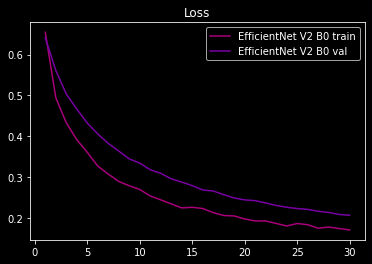

In [14]:
plt.style.use('dark_background')
loss = efficientnet_history.history.get('loss')
val_loss = efficientnet_history.history.get('val_loss')
epochs = np.arange(1, len(efficientnet_history.history.get('loss')) + 1)

plt.plot(epochs, loss, color = '#a9007a')
plt.plot(epochs, val_loss, color = '#7900a5')
plt.legend(("EfficientNet V2 B0 train", "EfficientNet V2 B0 val"))
plt.title('Loss')
plt.show()

# **2 - La matrice de confusion**

In [24]:
i=0
y_true = []
for l in Final_Test:
    i+=1
    for x in l[1]:
        y_true.append(x)
    if i>=len(Final_Test):
        break

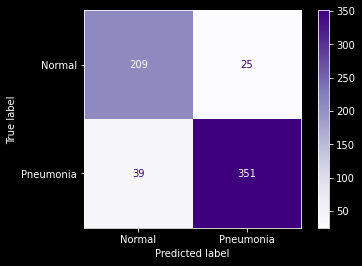

In [25]:
Final_Test.reset()

labels = ["Normal", "Pneumonia"]

efficientnet_predictions = efficientnet_model.predict(Final_Test)
y_pred = [1 if i > 0.75 else 0 for i in efficientnet_predictions]

efficientnet_matrix = confusion_matrix(y_true, y_pred)
efficientnet_disp = ConfusionMatrixDisplay(confusion_matrix=efficientnet_matrix, display_labels=labels)
efficientnet_disp.plot(cmap=plt.cm.Purples)
plt.show()

# **2 - Les scores**

In [26]:
Final_Test.reset()
score = efficientnet_model.evaluate(Final_Test) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

20/20 [==============================] - 6s 291ms/step - loss: 0.3532 - accuracy: 0.8285 - precision: 0.7859
Test loss: 0.3532002568244934
Test accuracy: 0.8285256624221802
